In [1]:
import json
from pathlib import Path
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def flatten(list_of_list):
    return [item for sublist in list_of_list for item in sublist]

path_to_training = Path("data/training")
path_to_test = Path("data/test")

In [2]:
#####
# training and test sets of transcription ids
#####
training_set = ['ES2002', 'ES2005', 'ES2006', 'ES2007', 'ES2008', 'ES2009', 'ES2010', 'ES2012', 'ES2013', 'ES2015', 'ES2016', 'IS1000', 'IS1001', 'IS1002', 'IS1003', 'IS1004', 'IS1005', 'IS1006', 'IS1007', 'TS3005', 'TS3008', 'TS3009', 'TS3010', 'TS3011', 'TS3012']
training_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in training_set])
training_set.remove('IS1002a')
training_set.remove('IS1005d')
training_set.remove('TS3012c')

test_set = ['ES2003', 'ES2004', 'ES2011', 'ES2014', 'IS1008', 'IS1009', 'TS3003', 'TS3004', 'TS3006', 'TS3007']
test_set = flatten([[m_id+s_id for s_id in 'abcd'] for m_id in test_set])

In [23]:
graph_links_labels= set()
for id in training_set:
    with open(path_to_training / f"{id}.txt", "r") as graphe:
        for line in graphe:
            l = line.split()
            graph_links_labels.add(l[1])
L = list(graph_links_labels)
int2label = {indice: valeur for indice, valeur in enumerate(L)}
label2int = {valeur: indice for indice, valeur in enumerate(L)}
label2int
N_vocab_links = len(L)

In [10]:
def get_transcript_and_graph(transcription_id):
    with open(path_to_training / f"{transcription_id}.json", "r") as file:
        json_transcription = json.load(file)

    N = len(json_transcription)
    transcription = np.empty((N,2), dtype='object')
    for utterance in json_transcription:
        transcription[int(utterance["index"]), 0] = utterance["speaker"]
        transcription[int(utterance["index"]), 1] = utterance["text"]
    G = nx.DiGraph()
    with open(path_to_training / f"{transcription_id}.txt", "r") as graphe:
        for line in graphe:
            l = line.split()
            G.add_edge(int(l[0]), int(l[2]), edge_type=label2int[l[1]])
    return transcription, G

def get_labels(transcription_id):
    with open("data/training_labels.json", "r") as file:
        training_labels = json.load(file)
    return training_labels[transcription_id]

In [11]:
id = training_set[10]

t, G,= get_transcript_and_graph(id)
print(G)


DiGraph with 869 nodes and 868 edges


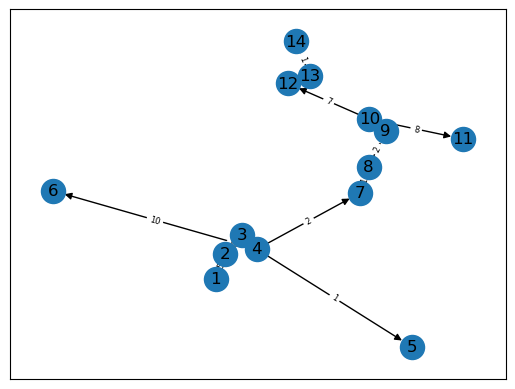

In [12]:
# Création d'un sous-graphe à partir du graphe original
selected_nodes = [i for i in range(1,15)]

G = G.subgraph(selected_nodes)

pos = nx.spring_layout(G)  # Layout pour une meilleure visualisation
labels = nx.get_edge_attributes(G, 'edge_type')

# Définition de la taille de la police pour les étiquettes des arêtes
edge_labels_font = {'font_size': 6}

nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=edge_labels_font['font_size'])
plt.show()

In [34]:
def in_out_count(graph):
    X = np.empty((len(graph.nodes()),2 * N_vocab_links))
    for node in graph.nodes():
        i = node - 1
        x = np.zeros(2 * N_vocab_links)
        arcs_entrants = G.in_edges(node, data=True)
        arcs_sortants = G.out_edges(node, data=True)
        for source, target, data in arcs_entrants:
            edge_type = data['edge_type']
            x[edge_type] += 1
        for source, target, data in arcs_sortants:
            edge_type = data['edge_type']
            x[N_vocab_links + edge_type] += 1
        X[i,:] = x
    return X

In [36]:
in_out_count(G).shape

(14, 32)

In [ ]:
X_train = 

In [42]:
#dont run that until you want to lose 15 min!!!!!
from sklearn.tree import DecisionTreeClassifier
from sentence_transformers import SentenceTransformer
bert = SentenceTransformer('all-MiniLM-L6-v2')


In [49]:
bert.encode("hello how are you and you").shape

(384,)

In [ ]:

X_training = bert.encode(X_training, show_progress_bar=True)

In [ ]:

clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_training, y_training)

test_labels = {}
for transcription_id in test_set:
    with open(path_to_test / f"{transcription_id}.json", "r") as file:
        transcription = json.load(file)
    
    X_test = []
    for utterance in transcription:
        X_test.append(utterance["speaker"] + ": " + utterance["text"])
    
    X_test = bert.encode(X_test)

    y_test = clf.predict(X_test)
    test_labels[transcription_id] = y_test.tolist()

with open("test_labels_text_baseline.json", "w") as file:
    json.dump(test_labels, file, indent=4)
